*Version: 30.01.2023*

<div class="alert alert-block alert-warning">
Executed with a small amount of train and test data to reduce throughput time $\rightarrow$ results presented are of limited significance!
</div>

> change `ensemble.train(0.01)` $\rightarrow$ `train(1)` and `develop` $\rightarrow$ `False` for full execution

<a href="https://www.w-hs.de/service/informationen-zur-person/person/nalbach/">
    <img src="https://www.w-hs.de/typo3conf/ext/whs/Resources/Public/Images/Pagelayout/w-hs_pagelogo.png"       alt="drawing" width="200" align="right"/>
</a>

<h1 align="center">  </h1>
<h1 align="center"> Maschine Learning 1 WS 22/23 </h1>
<h4 align="center"> Lennart Fuhrig </h4>


# Implementation of a Random Forest Ensemble for recognition of classification uncertainty on CIFAR-10 image data.
### Subtasks:
> * #### Data Preprocessing
> * #### Tuning of a Random Forest Base Classifier
> * #### Implementation and Training of Ensemble
> * #### Ensemble Evaluation

<a href="https://github.com/lennart2810/ML1">
    <img src="https://raw.githubusercontent.com/lennart2810/ML1/master/appendix/bagging.png"       alt="drawing" width="700" align="center"/>
</a>

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [3]:
#!pip install ipynb 

# import ensemble class and functions defined in separate script
from ipynb.fs.full.header_file import get_processed_data, MyEnsembleClassifier, plot_MRF

# Preprocessing

> ### `get_processed_data`
> uses three nested functions for laoding, preprocessing and splitting the dataset. It takes two optional arguments: `debug` indicates whether to print information during the process or not, whereas the `proportion` input is passed to the `split_train_data` function.
>> #### `load_dataset`
>> loads the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) using `keras.datasets`. It returns the train and test sets, including images and labels, as well as a dictionary that maps the numeric labels of the classes to their names.
>> #### `process_data`
>> performs several preprocessing steps on the dataset. It converts the images to grayscale, scales them from 0-255 to 0-1 and flattens the images.
>> #### `split_train_data`
>> devides the train data into two parts: an *unique* and an *overlapping* set. The `proportion` input is a value between 0 and 1 indicating the proportion of the data to be used as the *overlap* subset.
> #### example:
>```python
>train, unique, overlap, test, class_dict = get_processed_data(debug=True, proportion=0.2)
>```
A proportion of 20% of the `train` data will be used as the `overlap` subset, remainig samples are stored in the `unique` one. All data outputs are defined as a `list`, each containing a numpy array for the images `(N, 1024)` and labels `(N, )`.

> For code use: `get_processed_data??`

In [4]:
# call preprocessing function
train_data, unique_data, overlap_data, test_data, class_dict = get_processed_data(proportion=0.2, debug=True)

1. load CIFAR-10 dataset:

train:	(50000, 32, 32, 3), (50000, 1)
test:	(10000, 32, 32, 3), (10000, 1)

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

2. preprocess dataset:

train:	(50000, 1024), (50000,)
test:	(10000, 1024), (10000, 1024)

3. prepare train data for ensemble:

unique:	(40000, 1024), (40000,)
overlap:(10000, 1024), (10000,)


In [5]:
# print exemplary information for the training data
print(f'train data:\t{len(train_data)}\t\t{type(train_data)}')
print(f'train images:\t{train_data[0].shape}\t{type(train_data[0])}')
print(f'train labels:\t{train_data[1].shape}\t{type(train_data[1])}')

train data:	2		<class 'list'>
train images:	(50000, 1024)	<class 'numpy.ndarray'>
train labels:	(50000,)	<class 'numpy.ndarray'>


<br>

# Step 1: Random Forest Base Classifier

> The following example code uses [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated) to find the best hyperparameters for a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) by training and evaluating the `grid_search` object with all possible combinations specified in the `param_grid`. The best set can be extracted to define the **RF Base Classifier**.

```python
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {'max_depth': [None, 5, 10], 
              'n_estimators': [50, 100, 150],
              'min_samples_leaf': [1, 2, 5, 10], 
              'max_features': ["sqrt", "log2", None]}

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid)
grid_search.fit(train_images, train_labels)
```

In [6]:
# define random forest base classifier with parameters determined by GridSearchCV
def rf_base_clf():
    return RandomForestClassifier(n_estimators=100, 
                                  min_samples_leaf=2, 
                                  max_features=None, 
                                  max_depth=None, 
                                  verbose=0)

<br>

# Step 2: Create and Train Bagging Ensemble

> ### `MyEnsembleClassifier`
creates an ensemble of classifiers using bagging. It takes three input arguments: `base_classifier`: a function that returns the Random Forest Base Classifier object, `n_classifier`: an integer representing the number of classifiers and `class_dict`: a dictionary containing class labels and descriptions.
The class has several methods:
> #### `init` 
initializes the class by creating a list of the specified base classifiers and storing information about the dataset as class attributes.
> #### `create_subsets`
takes two datasets (`unique` and `overlap`) and an predefined `overlap_dictonary` as inputs. It creates subsets  for each ensemble member to train on by using a combination of sequential sampling from the *unique* subset and random sampling from the *overlapping* one.
> #### `train`
fits each ensemble member to the subset of data created in the `create_subsets` method. An optional `proportion` parameter can be passed in to reduce the size of the dataset and speed up training during development.
> #### `evaluate`
takes in two parameters: `images` and `labels`. The method first iterates over each classifier, gets the accuracy scores using the `score` method and means them to an ensemble accuracy. 
Afterwards it iterates over all classifiers to get their predictions for the input images using the `predict` method. 
These predictions are stored in an array of shape `N_images, N_classifier` where each element `i,j` is the class predicted by the `classifier_j` for `image_i`.
The number of predictions for each class and images is counted and divided by the total number of classifiers to calculate the relative frequencies. 
The ensemble prediction for each image is determined by the index of the highest value of the relative predictions array, which is also the measure of the certainty of the ensemble prediction.

In [7]:
# define number of ensemble members
n_clf = 20

# predefined number of samples for the each overlapping subset
overlap_dict = {10:6000, 20:5000, 40:3000} 

In [8]:
# initialize the ensemble
ensemble = MyEnsembleClassifier(rf_base_clf, n_clf, class_dict)

initialized ensemble with 20 RandomForestClassifier(max_features=None, min_samples_leaf=2)


In [9]:
# call method to create subsets
ensemble.create_subsets(unique_data, overlap_data, overlap_dict)

created 20 subsets, each containing the following:

images:	(7000, 1024)
labels:	(7000,)


In [10]:
# train ensemble
ensemble.train(0.01) # train each classifier on 1% of their corresponding subset (default=1 for full training)

train each classifier on their corresponding subset:

1. classifier
2. classifier
3. classifier
4. classifier
5. classifier
6. classifier
7. classifier
8. classifier
9. classifier
10. classifier
11. classifier
12. classifier
13. classifier
14. classifier
15. classifier
16. classifier
17. classifier
18. classifier
19. classifier
20. classifier

training duration: 25.22 s


<br>

# Step 3: Evaluate Ensemble

> ### `evaluation`
is called by the following `main` function to iterate over all images and check if an ensemble prediction `pred` is subject to uncertainty by comparing the confidence level `o_max` to a `threshold`. If it is uncertain, `M` is incremented and the function checks if `pred` is correct or wrong, incrementing `R` or `F` respectively.
Once the loop is finished, the function relativizes the values to the number of images `N`.
> ### `main`
evaluates the ensemble on a given dataset using the `ensemble.evaluate` method. A list of results for different thresholds in the range of 0 to 1 is created by calling `evaluation` during a list comprehension. Finally, the results are visualized using the `plot_MRF` function.

In [11]:
# reduce evaluation time if needed
develop = True

if develop:

    samples = 200
    test_data[0] = test_data[0][:samples]
    test_data[1] = test_data[1][:samples]

    train_data[0] = train_data[0][:samples]
    train_data[1] = train_data[1][:samples]

In [12]:
def evaluation(labels, ensemble_pred, ensemble_pred_confi, treshold):

    N, M, R, F = len(labels), 0, 0, 0

    # iterate over all images 
    for label, pred, o_max in zip(labels, ensemble_pred, ensemble_pred_confi):    

        # is the ensemble prediction subject to uncertainty? 
        if o_max < treshold: 
            M += 1

            # is the uncertain prediction right or wrong?
            if pred == label: R += 1
            else: F += 1
                
    if M != 0:
        # relativize values to N (number of images) (R, F already relative to M)
        M = M / N
        R = R / N
        F = F / N 
            
    return [M, R, F, treshold]

In [13]:
# create horizontal axis
treshold_range = (np.round(np.arange(0, 1.1, 0.1), 2)) 

def main(data, data_name):
    
    # extract images and labels from given data set
    images, labels = data[0], data[1]
    
    # evaluate ensemble on given dataset
    acc, pred, relative_pred, ensemble_pred, ensemble_pred_confi = ensemble.evaluate(images, labels)
    
    # print ensemble evaluation info
    print(f'accuracy:\t\t{round(acc, 3)}\t\t{type(acc)}')
    print(f'predictions:\t\t{pred.shape}\t{type(pred)}')
    print(f'relative predictions:\t{relative_pred.shape}\t{type(relative_pred)}')
    print(f'ensemble prediction:\t{ensemble_pred.shape}\t{type(ensemble_pred)}')
    print(f'ensemble confidence:\t{ensemble_pred_confi.shape}\t{type(ensemble_pred_confi)}')

    # evaluation for given thresholds
    results = [evaluation(labels, ensemble_pred, ensemble_pred_confi, treshold) for treshold in treshold_range]
    
    # plot results via plotting function 
    title = f'{ensemble.clf_n} classifier on {data_name} dataset (accuracy: {round(acc * 100, 3)}%)'
    plot_MRF(results, title)

accuracy:		0.171		<class 'numpy.float64'>
predictions:		(200, 20)	<class 'numpy.ndarray'>
relative predictions:	(200, 10)	<class 'numpy.ndarray'>
ensemble prediction:	(200,)	<class 'numpy.ndarray'>
ensemble confidence:	(200,)	<class 'numpy.ndarray'>


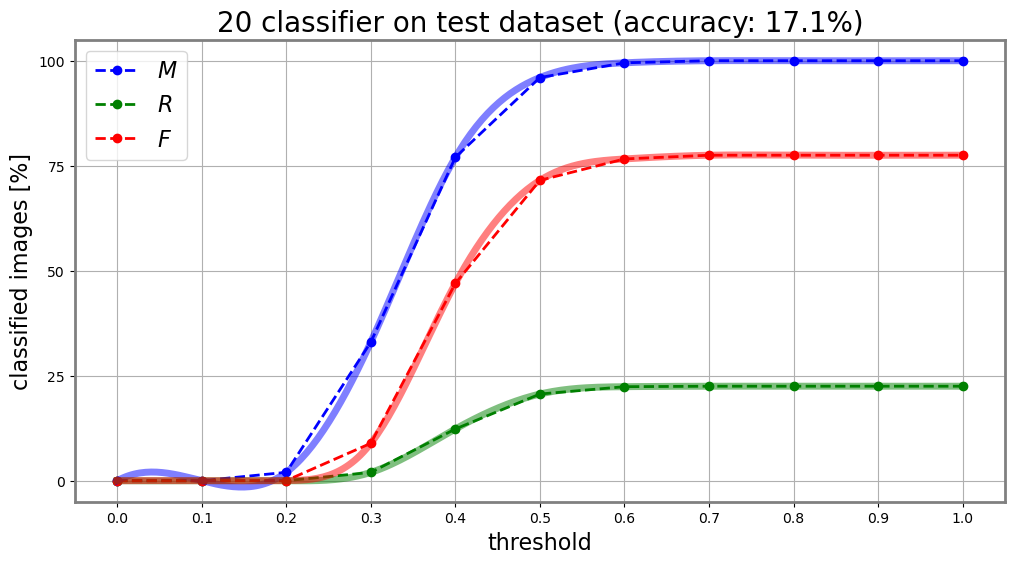

In [14]:
# evaluate test dataset
main(test_data, 'test')

accuracy:		0.156		<class 'numpy.float64'>
predictions:		(200, 20)	<class 'numpy.ndarray'>
relative predictions:	(200, 10)	<class 'numpy.ndarray'>
ensemble prediction:	(200,)	<class 'numpy.ndarray'>
ensemble confidence:	(200,)	<class 'numpy.ndarray'>


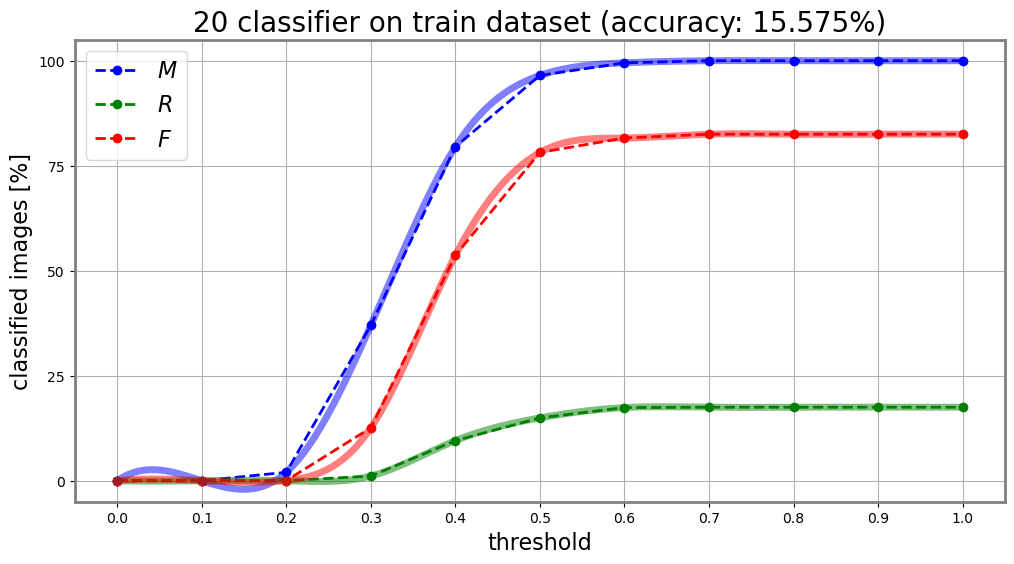

In [15]:
# evaluate train dataset
main(train_data, 'train')